This notebook is used to train an emulator given some training and testing data, and to then plot the emulator error(s) as a function of $k$. The "tier2_XL" data referenced here and elsewhere is too large to upload to GitHub. To retrieve it, visit 10.5281/zenodo.17363645

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import chaospy as cp
import yaml
import h5py
import json
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.interpolate import make_smoothing_spline
from glob import glob
import GPy

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 12

def norm(x, x_mean=None, x_mult=None):

    if x_mean is None:
        x_mean = np.mean(x, axis=0)

    if x_mult is None:
        x_mult = 2 / (np.max(x, axis=0) - np.min(x, axis=0))

    x_normed = (x - x_mean[np.newaxis, ...]) * x_mult[np.newaxis, ...]

    return x_normed, x_mean, x_mult


def unnorm(x_normed, x_mean, x_mult):

    x = x_normed / x_mult[np.newaxis, ...] + x_mean[np.newaxis, ...]

    return x

class Emulator(object):

    def __init__(self, n_pcs, k, smooth_spectra=True, window=11, savgol_order=3,
                 surrogate_type='PCE'):
        
        self.n_pcs = n_pcs
        self.smooth_spectra = smooth_spectra
        self.window = window
        self.savgol_order = savgol_order
        self.nk = len(k)
        self.k = k
        self.surrogate_type = surrogate_type
        

    
    def _get_pcs(self, evec_spec, spectra, npc):

        pcs_spec = np.dot(spectra, evec_spec[:, :npc])

        return pcs_spec


    def train(self, x, y, npoly=[1], qtrunc=1):
        
        evec_spec = np.zeros((self.nk, self.nk))
        
        if not hasattr(npoly, '__iter__'):
            npoly = [npoly] * x.shape[1]
        elif len(npoly) == 1:
            npoly *= x.shape[1]
            
        # computing PCs
        if self.smooth_spectra:
            ysmooth = savgol_filter(y, self.window,
                                 self.savgol_order, axis=-1)
        else:
            ysmooth = y
        
        ycov = np.cov(ysmooth.T)
        self.vars_spec, self.evec_spec = np.linalg.eig(ycov)
        pcs_spec = np.dot(ysmooth, self.evec_spec[:, :self.n_pcs])

        x_normed, param_mean, param_mult = norm(x)
        self.param_mean = param_mean
        self.param_mult = param_mult
        self.param_ranges_scaled = np.vstack([np.min(x_normed, axis=0), np.max(x_normed, axis=0)])
        self.param_ranges_scaled = self.param_ranges_scaled.T

        if self.surrogate_type == 'PCE':

            distribution = cp.J(*[cp.Uniform(self.param_ranges_scaled[i][0],
                                             self.param_ranges_scaled[i][1]) for i in range(x_normed.shape[1])])

            # PCE coefficient regression
            pce = cp.orth_ttr(npoly, distribution,
                                  cross_truncation=qtrunc, graded=True)
            # print(pce.shape)
            # print(pce)
            self.surrogate = cp.fit_regression(pce, x_normed.T, np.real(pcs_spec))
            
        if self.surrogate_type == 'GP':
            # Uncomment the below line to use isotropic RBF kernel
            # kernel = GPy.kern.RBF(input_dim=x_normed.shape[1], variance=1., lengthscale=1.)

            # Anisotropic RBF kernel
            kernel = GPy.kern.RBF(input_dim=x_normed.shape[1], ARD=True, lengthscale=np.ones(x_normed.shape[1]).tolist())
            self.surrogate = GPy.models.GPRegression(x_normed, np.real(pcs_spec), kernel=kernel)
            self.surrogate.optimize()
            print(self.surrogate.flattened_parameters) #printing length scales
            # np.savetxt('emulator_errors/pmm_w0wamnu_noisy_ZCV_tier2/pmm_w0wamnu_noisy_ZCV_tier2_v4_GP_length_params.txt', self.surrogate.flattened_parameters)
            

    def predict(self, x):
        xnorm, _, _ = norm(x, self.param_mean, self.param_mult)
        if self.surrogate_type == 'PCE':
            ypred = self.surrogate(*(xnorm.T))
            ypred = np.dot(self.evec_spec[:,:self.n_pcs], ypred).T

        else:
            ypred, _ = self.surrogate.predict(xnorm)
            ypred = np.dot(self.evec_spec[:,:self.n_pcs], ypred.T).T

        
        return ypred

# try 3 and 4 for order
def compute_error_stats(P, F, F_c, P_test, F_test, F_c_test, k, npc=10,
                        order=3, use_z=False, logmnu=False,
                        return_all_err=False, surrogate_type='PCE'):
    """
    P : array training parameters with shape (N_sims, N_pars). Right now order is expected to be As, ns, H0, w0, wa, ombh2, omch2, nu_mass_ev, time (e.g. redshift)
    F: array of simulation measurements we wish to emulate with shape (N_sims, nk).
    F_c : array of LPT predictions at the same cosmologies/redshifts as the sim measurements with shape (N_sims, nk). We emulate the ratio of F/F_c.
    P_test: array test parameters with shape (N_test, N_pars).
    F_test: array of test measurements we wish to measure the emulator error against with shape (N_test, nk).
    F_c_test: array of LPT predictions at the same cosmologies/redshifts as F_test with shape (N_test, nk).
    k: array of wavenumbers of shape (nk)
    npc: Number of principle components to decompose F/Fc into.
    order: Order of the PCE (if using PCE as surrogate type)
    use_z: Whether to use redshift or scale factor as the time variable. Only relevant if time variable being passed in P/P_test is redshift.
    logmnu: If true, use logmnu instead of mnu as parameter. Expects this to be the second to last parameter in P/Ptest.
    
    returns:
    stderr: The 50th, 68th, 95th and 99th percentile error averaged across k for each point in test parameter space.
    kerr: The 50th, 68th, 95th and 99th percentile error as a function of k over the whole test parameter space.
    emu: Emulator object.
    """

    Ptrain = np.copy(P)
    F_r = F / F_c
    F_r_test = F_test/ F_c_test

    # These for loops use a spline to smooth over wiggles in F_r, significantly reducing emulator error
    #   for lower-k, especially for tier 1. If you don't wish to smooth, comment-out the for-loops.
    
    lam = 0.005
    idx_min = 190
    idx_max = 525

    for i in range(F_r.shape[0]):
        spl = make_smoothing_spline(k[idx_min:idx_max], (F_r)[i,idx_min:idx_max], lam=lam, w=10*np.array(1-np.exp(-((k[idx_min:idx_max]-0.4)/(0.1))**2)))
        F_r[i,idx_min:idx_max] = spl(k[idx_min:idx_max])

    for i in range(F_r_test.shape[0]):
        spl = make_smoothing_spline(k[idx_min:idx_max], (F_r_test)[i,idx_min:idx_max], lam=lam, w=10*np.array(1-np.exp(-((k[idx_min:idx_max]-0.4)/(0.1))**2)))
        F_r_test[i,idx_min:idx_max] = spl(k[idx_min:idx_max])


    if logmnu:
        Ptrain[:,-2] = 10**Ptrain[:,-2]
        P_test[:,-2] = 10**P_test[:,-2]
        
    Pmean = np.mean(Ptrain, axis=0)
    Pstd = np.std(Ptrain, axis=0)
    Ptrain_norm = (Ptrain - Pmean) / Pstd
    Ptest_norm = (P_test - Pmean) / Pstd  
    
    Ftrain =  np.log10(F_r)
    Ftrain[Ftrain!=Ftrain] = 0
    
    k = np.logspace(-3, 0, 100)
    emu = Emulator(npc, k, surrogate_type=surrogate_type)
    emu.train(Ptrain_norm, Ftrain, npoly=order)
    
    pmin = np.min(Ptrain_norm, axis=0)
    pmax = np.max(Ptrain_norm, axis=0)
    delta_p = (pmax - pmin)
    frac_design = 1
    pmin = pmin + delta_p * (1-frac_design) / 2 
    pmax = pmax - delta_p * (1-frac_design) / 2

    idx = np.all((Ptest_norm >= pmin[np.newaxis,:]) & (Ptest_norm <= pmax[np.newaxis,:]), axis=1)
    Fpred = emu.predict(Ptest_norm[idx])
    err = np.abs((10**Fpred - F_r_test[idx])/ F_r_test[idx])
    x = P_test[idx]
    stderr = np.percentile(err, [50, 66, 95, 99], axis=1)
    kerr = np.percentile(err, [50, 66, 95, 99], axis=0)
       
    return stderr, kerr, emu # Fpred, Ptest_norm, F_r_test

In [14]:
idx_max = 539 #k=1
# idx_max = 497 #k=0.7
# idx_max = 479 #k=0.6

In [15]:
train_dir = 'training_data/' # where all training data lives
data_dir = 'tier2_XL/' # where data to be used to train this emulator lives
hmcode_training_data_file=train_dir+data_dir+'pk_hmcode.npy'
lpt_training_data_file=train_dir+data_dir+'pk_1L.npy' # N cosmologies, 30 redshifts, 700 ks
training_cosmo_file=train_dir+data_dir+'params.txt' # N cosmologies, 8 cosmological parameters
zs = np.load('./aemulus_data/zs.npy') # 30 redshifts

sigma_8 = np.loadtxt(train_dir+data_dir+'sigma_8.txt') # sigma_8(z) for all runs
k = np.loadtxt(train_dir+data_dir+'k_out.txt') # 700 ks

F = np.load(hmcode_training_data_file)
F_c = np.load(lpt_training_data_file)
P = np.genfromtxt(training_cosmo_file)

# Uncomment below to train on just the last X cosmologies in a dataset. Set X=0 to use all. Use idx_max to truncate k-range.
X = 0
F = F[-X:, :, :idx_max]
F_c = F_c[-X:, :, :idx_max]
P = P[-X:,:]
sigma_8 = sigma_8[-X:]

print(P.shape)

# If you want to, for example, train on wCDM, you should remove the parameter column corresponding to w_a 
#   by uncommenting the below lines
# print(P[0])
# P = np.delete(P, [3], axis=1)
# print(P.shape)

P = np.repeat(P, F.shape[1], axis=0) # repeat N cosmologies 30 times: (N*30, 7)
P = np.hstack((P, sigma_8.flatten().reshape(len(sigma_8.flatten()),1))) # adding sigma_8 as final column

F = F.reshape(-1, F.shape[-1]) # Shape: 6000, 700
F_c = F_c.reshape(-1, F_c.shape[-1]) # Shape: 6000, 700

(1000, 8)


In [16]:
k = np.loadtxt(train_dir+data_dir+'k_out.txt') # 700 ks

In [17]:
test_dir = 'testing_data/' # where all testing data lives
# data_dir = 'pmm_w0wamnu_noisy_ZCV_tier1/'
hmcode_test_data_file=test_dir+data_dir+'pk_hmcode.npy'
lpt_test_data_file=test_dir+data_dir+'pk_1L.npy'
test_cosmo_file=test_dir+data_dir+'params.txt'

sigma_8_test = np.loadtxt(test_dir+data_dir+'sigma_8.txt') #sigma_8(z) for all runs
F_test = np.load(hmcode_test_data_file)
F_c_test = np.load(lpt_test_data_file)
P_test = np.genfromtxt(test_cosmo_file)

X = 100
F_test = F_test[-X:, :, :idx_max]
F_c_test = F_c_test[-X:, :, :idx_max]
P_test = P_test[-X:,:]
sigma_8_test = sigma_8_test[-X:]

P_test = np.repeat(P_test, F_test.shape[1], axis=0)
P_test = np.hstack((P_test, sigma_8_test.flatten().reshape(len(sigma_8_test.flatten()),1)))

F_test = F_test.reshape(-1, F_test.shape[-1])
F_c_test = F_c_test.reshape(-1, F_test.shape[-1])



In [22]:
stderr_full, kerr_full, emu = compute_error_stats(P, F, F_c, P_test, F_test, 
                                                  F_c_test, k[:idx_max], npc=12,
                                                    order=3)

savedir = 'emulator_errors'
# create emulator_errors directory before running
np.savetxt(savedir+'/'+'tier2_XL_npc12_stderr.txt', stderr_full)
np.savetxt(savedir+'/'+'tier2_XL_npc12_kerr.txt', kerr_full)


chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


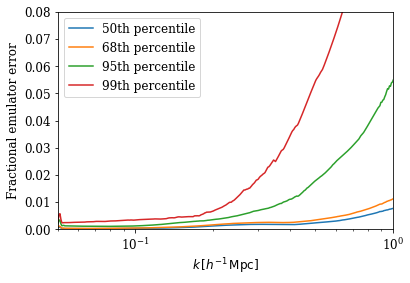

In [23]:
plt.semilogx(k[:idx_max], kerr_full.T)
plt.xlim(0.05,1)
plt.ylim(0,0.08)
plt.legend(['50th percentile', '68th percentile', '95th percentile', '99th percentile'])
plt.xlabel(r'$k\, [h^{-1}\, {\rm Mpc}]$')
plt.ylabel('Fractional emulator error')

plt.show()